# Модуль 3

Импортируем библиотеки для загрузки БД из прошлой сессии

In [47]:
# Импорт модуля pandas
import pandas as pd
import numpy as np
# Игнорирование предупреждений
import warnings
warnings.filterwarnings('ignore')

In [48]:
# Импорт библиотек
df = pd.read_csv('data.csv', low_memory=False)
df.drop(['Unnamed: 0'], axis = 1, inplace = True)
df.drop(['location'], axis = 1, inplace = True)
df.drop(['new_cases_per_million'], axis = 1, inplace = True)
df.drop(['new_cases_smoothed_per_million'], axis = 1, inplace = True)
df.drop(['new_deaths_per_million'], axis = 1, inplace = True)
df.drop(['new_deaths_smoothed_per_million'], axis = 1, inplace = True)
df.drop(['new_tests_smoothed'], axis = 1, inplace = True)
df.drop(['population'], axis = 1, inplace = True)
df.drop(['population_density'], axis = 1, inplace = True)
df.drop(['gdp_per_capita'], axis = 1, inplace = True)

## 3.1 Построение регрессионной модели

Для предсказания кол-ва новых случаев заражения COVID-19 в различных странах необходимо построить регрессионную модель. Есть несколько различных вариантов:
1. *Linear Regression*
2. *Полиноминальная регрессия*
3. *Ridge*

Для построение регрессионной модели сначала нужно определиться с X и Y. Раз у нас задача на числовой прогноз данных (предсказать перспективу распространения COVID-19 по датам), то нам определённо нужен столбец **date**. Осталось выбрать переменную, которая показывала бы распространение болезни. 

In [49]:
df.dtypes

date                          object
new_cases_smoothed           float64
new_deaths_smoothed          float64
new_vaccinations_smoothed    float64
aged_65_older                float64
cardiovasc_death_rate        float64
diabetes_prevalence          float64
female_smokers               float64
male_smokers                 float64
dtype: object

Из всех признаков наиболее подходящим является **new_cases_smoothed**. Потому что он отражает сглаженную статистику новых случаев заболевания, именно это и требуется в задании.

*Разделим данные снова на обучающую и тестовую выборки для построения моделей регресии*

In [50]:
# Введение переменных (X = входные данные, y = выходные данные (ответ))
X = df['new_cases_smoothed'].values.reshape(-1,1)  / 100000

import datetime as dt
date = pd.to_datetime(df['date'])
date = date.map(dt.datetime.toordinal)
y = date / 100000 # Введение y за ответ

from sklearn.model_selection import train_test_split
# Введение тренировочной и тестовой частей (70% - тренировочная, 30% - тестовая. Шаг 11 записей)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=11)

Построим *Linear Regression*

Склон: 0.00
Перехват: 1.01


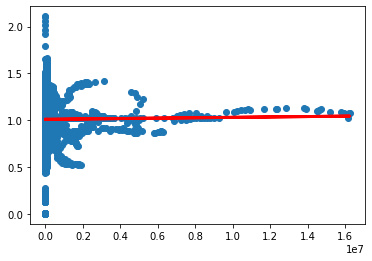

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

# Модель линейной регрессии
from sklearn.linear_model import LinearRegression
slr = LinearRegression()
slr.fit(X, y)
y_pred = slr.predict(X)
print('Склон: {:.2f}'.format(slr.coef_[0]))
print('Перехват: {:.2f}'.format(slr.intercept_))

# Вывод модели
plt.scatter(X, y)
plt.plot(X, slr.predict(X), color='red', linewidth=3);

In [59]:
# Построение интерактивной линейной регрессии
fig = px.scatter(
    df, x= date / 100000, y='new_cases_smoothed', opacity=0.65,
    trendline='ols', trendline_color_override='darkblue'
)
fig.show()

**Вывод: Как можно заметить, линейная регрессия с одной независимой переменной показывает неудачные результаты, так как является практически параллельной оси абсцисс. Поэтому предсказание будет одним и тем же**

Построим *Полиноминальную регрессию*

In [ ]:
from sklearn.preprocessing import PolynomialFeatures
regr = LinearRegression()

# create quadratic features
quadratic = PolynomialFeatures(degree=2)
cubic = PolynomialFeatures(degree=3)
X_quad = quadratic.fit_transform(X)
X_cubic = cubic.fit_transform(X)

# fit features
X_fit = np.arange(X.min(), X.max(), 1)[:, np.newaxis]

regr = regr.fit(X, y)
y_lin_fit = regr.predict(X_fit)
linear_r2 = r2_score(y, regr.predict(X))

regr = regr.fit(X_quad, y)
y_quad_fit = regr.predict(quadratic.fit_transform(X_fit))
quadratic_r2 = r2_score(y, regr.predict(X_quad))

regr = regr.fit(X_cubic, y)
y_cubic_fit = regr.predict(cubic.fit_transform(X_fit))
cubic_r2 = r2_score(y, regr.predict(X_cubic))

Построим *Ridge*

In [60]:
from sklearn.linear_model import Ridge

clf = Ridge(alpha=1.0)
clf.fit(X, y)

Ridge()

После построения регрессионных моделей нужно выбрать одну из них. Для этого существуют метрики оценки качества рабочей модели.
1. *Accuracy*
2. *Precision & Recall*
3. *F1*
4. *MAE*
5. *ROC*

Метрика *Accuracy*

In [ ]:
from sklearn.metrics import accuracy_score

print(accuracy_score(y_pred, y_true))

Метрика *Precision & Recall*

In [ ]:
from sklearn.metrics import precision_score, recall_score

print(precision_score(y_pred, y_true))
print(recall_score(y_pred, y_true))

Метрика *F1*

In [ ]:
from sklearn.metrics import f1_score

print(f1_score(y_true, y_pred))

Метрика *ROC*

In [ ]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

#Создание и ввод переменных
logreg = LogisticRegression()
logreg.fit(X_train, y_train)
logit_roc_auc = roc_auc_score(y_test, logreg.predict(X_test))
fpr, tpr, thresholds = roc_curve(y_test, logreg.predict_proba(X_test)[:,1])

#Построение графика
plt.figure()
plt.plot(fpr, tpr, label='Логистическая регрессия (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Отрицательный')
plt.ylabel('Позитивный')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.show()

## 3.2 Визуализация работы модели

In [53]:
import plotly.express as px

fig = px.line(df, x='date', y='new_cases_smoothed')
fig.show()

In [54]:
import plotly.express as px

fig = px.line(df, x='date', y='new_vaccinations_smoothed')
fig.show()

На графике видно, что за последний месяц кол-во вакцинированных людей от COVID-19 резко растёт

## 3.3 Отчёт

Вывод по сессии: Были проанализированы признаки, которые могут быть использованы в предсказании заболеваний, были построены модели регрессии и проверена их точность с помощью метрик. Была выбрана модель **Полиноминальной регрессии** и метрика **Accuracy**, потому что они показали лучшую точность.

В датасете присутствуют признаки:
- Дата
- Новые случаи заболевания (сглаженные данные)
- Новые смерти (сглаженные данные)
- Новые люди с вакцинацией (сглаженные данные)
- Возростная группа 65 и старше
- Смерти от сердечнососуд заболеваний
- Диабетики
- Курящие женщины
- Курящие мужчины 

К отчёту прилагаю
1. Код
2. Обработанную БД
3. HTML отчёт работы

In [67]:
# Сохранение БД
df.to_csv('output_M3.csv')

In [69]:
#Сохранение в HTML
!jupyter nbconvert C8_M3.ipynb --to html

[NbConvertApp] Converting notebook C8_M3.ipynb to html
[NbConvertApp] Writing 1621035 bytes to C8_M3.html
